# 1.EDA и Preprocessing

## Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
import umap

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('C:\\Users\\algol\\Downloads\\german_credit_data.csv')


## Изучим данные

In [ ]:
#функция для вывода состава столбцов
def describe_cols(df_data):
    df = df_data
    values = pd.DataFrame()
    
    for col in df.columns:
        values[col] = [df[col].unique(), df[col].dtypes, df[col].nunique()]
        
    return values.transpose().sort_values(by=1, ascending=True).rename(
        {0: 'Значения', 1: 'тип данных', 2: 'Кол-во уникальных значений'}, axis=1)


#функция для вывода пустых значений и их доли в столбцах датафрейма, 
#а также явных дубликатов
def nan_values(df_data):
    df = df_data
    count_missing = df.isna().sum()
    percent_missing = round(df.isna().sum() * 100 / len(df), 2)
    count_duplicates = df.duplicated().sum()
    
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'num_missing': count_missing,
                                     'percent_missing': percent_missing,
                                     'num_duplicates': count_duplicates})
    
    return missing_value_df


#функция для вывода информации о файле
def df_info (df_data):
    print('Количество строк файла:', df_data.shape[0])
    print('Количество столбцов файла:', df_data.shape[1])
    print()
    print('Информация о содержимом файла:')
    display(describe_cols(df_data))
    print()
    print('Информация о пропусках и явных дубликатах данных:')
    display(nan_values(df_data))
    print()
    print('Первые пять строк таблицы:')
    display(df_data.head())

In [ ]:
df_info(df)

Количество строк файла: 1000
Количество столбцов файла: 10

Информация о содержимом файла:


,Значения,тип данных,Кол-во уникальных значений
Unnamed: 0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",int64,1000
Age,"[67, 22, 49, 45, 53, 35, 61, 28, 25, 24, 60, 3...",int64,53
Job,"[2, 1, 3, 0]",int64,4
Credit amount,"[1169, 5951, 2096, 7882, 4870, 9055, 2835, 694...",int64,921
Duration,"[6, 48, 12, 42, 24, 36, 30, 15, 9, 10, 7, 60, ...",int64,33
Sex,"[male, female]",object,2
Housing,"[own, free, rent]",object,3
Saving accounts,"[nan, little, quite rich, rich, moderate]",object,4
Checking account,"[little, moderate, nan, rich]",object,3
Purpose,"[radio/TV, education, furniture/equipment, car...",object,8



Информация о пропусках и явных дубликатах данных:


,column_name,num_missing,percent_missing,num_duplicates
Unnamed: 0,Unnamed: 0,0,0.0,0
Age,Age,0,0.0,0
Sex,Sex,0,0.0,0
Job,Job,0,0.0,0
Housing,Housing,0,0.0,0
Saving accounts,Saving accounts,183,18.3,0
Checking account,Checking account,394,39.4,0
Credit amount,Credit amount,0,0.0,0
Duration,Duration,0,0.0,0
Purpose,Purpose,0,0.0,0



Первые пять строк таблицы:


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


## Предобработка

In [ ]:
# удалим столбец Unnamed, т.к. в ней просто идут цифры по порядку и она не несет информации
df = df.drop('Unnamed: 0', axis=1)
# переименуем столбцы
df.columns = df.columns.str.replace(' ', '_').str.lower()
df

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car
...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,NaN,1736,12,furniture/equipment
996,40,male,3,own,little,little,3857,30,car
997,38,male,2,own,little,NaN,804,12,radio/TV
998,23,male,2,free,little,little,1845,45,radio/TV


В столбцах saving_accounts и	checking_account очень много пропусков, поэтому просто удалить строки с пропусками нельзя. Мы строковые значения этих столбцов будем переводить в "уникальные лэйблы", поэтому заменим Nan на строку "no_info'. 

Таблица содержит следующие столбцы:
<div>'age' — возраст;
<div>'sex' — Пол;
<div>'job' - работа, <div>'housing' - тип дома, <div>'saving_accounts' - накопительные счета, <div>'checking_account' - текущие счета,
       <div>'credit_amount' - размер кредита, <div>'duration' - длительность кредита, <div>'purpose' - цель кредита.

In [ ]:
df['checking_account'] = df['checking_account'].fillna('no_info')

In [ ]:
df['saving_accounts'] = df['saving_accounts'].fillna('no_info')
df.isna().mean()

age                 0.0
sex                 0.0
job                 0.0
housing             0.0
saving_accounts     0.0
checking_account    0.0
credit_amount       0.0
duration            0.0
purpose             0.0
dtype: float64

От пропусков избавились

## Корреляции

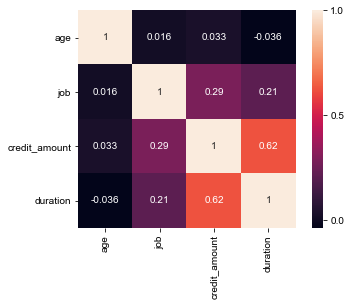

In [ ]:
#Построим матрицу корреляций и тепловую карту 
cm = df.corr() #вычисляем матрицу корреляций

#нарисуем тепловую карту с подписями для матрицы корреляций
sns.heatmap(cm, annot=True, square=True) 
sns.set(font_scale=2,rc = {'figure.figsize':(20,20)})

plt.show()

Признаки имеют низкую корреляцию. 

## Масштабирование данных

Нормализация данных нужна, чтобы привести все данные к схожей размерности. Если данные в различных признаках будут отличаться на порядок, то кластеризация пройдет не корректно. 

In [ ]:
df

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose
0,67,male,2,own,no_info,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,no_info,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car
...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,no_info,1736,12,furniture/equipment
996,40,male,3,own,little,little,3857,30,car
997,38,male,2,own,little,no_info,804,12,radio/TV
998,23,male,2,free,little,little,1845,45,radio/TV


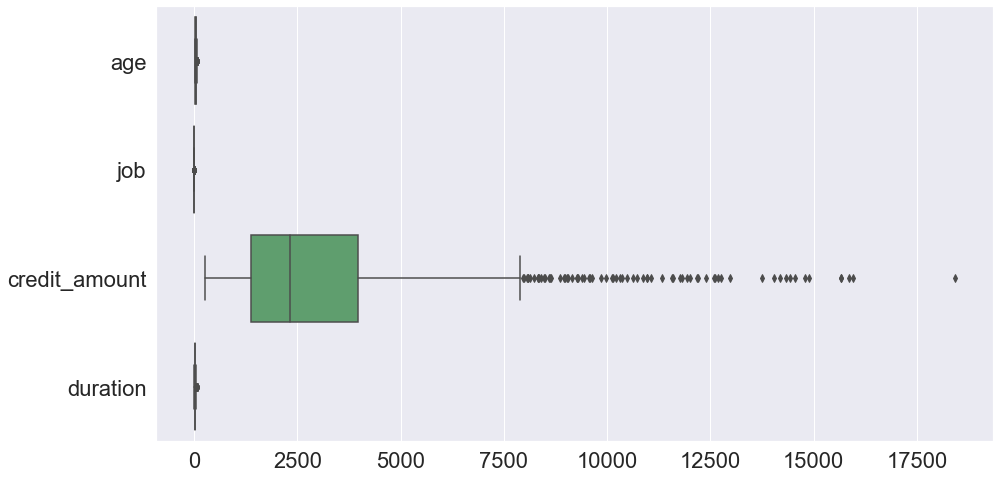

In [ ]:
# посмотрим на разброс до нормализации
import seaborn as sns
plt.figure(figsize=(15,8))
sns.boxplot(data=df, orient='h');

In [ ]:
# нормализуем вещественные данные
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['age', 'credit_amount', 'duration']])
df_sc = pd.DataFrame(X_scaled, columns=['age', 'credit_amount', 'duration'])
df_sc.head()

,age,credit_amount,duration
0,2.766456,-0.745131,-1.236478
1,-1.191404,0.949817,2.248194
2,1.183312,-0.416562,-0.738668
3,0.831502,1.634247,1.750384
4,1.535122,0.566664,0.256953


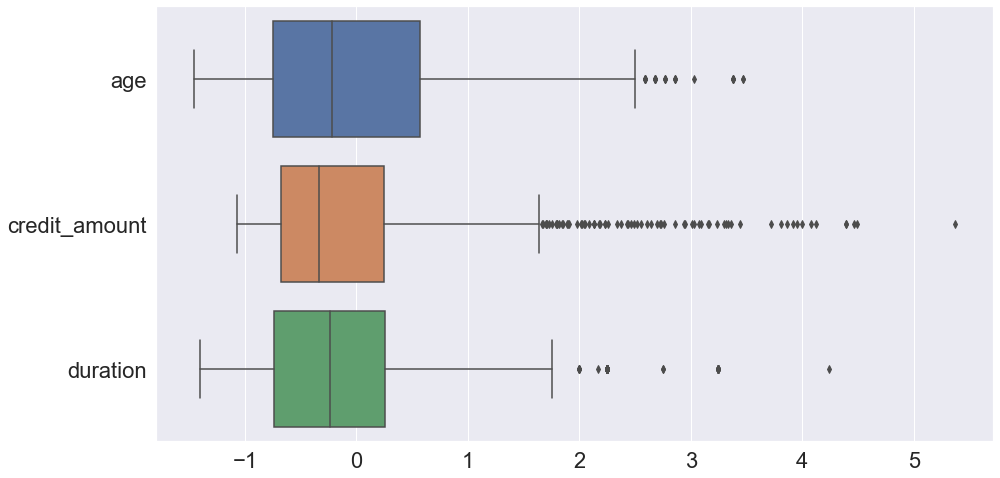

In [ ]:
# оценим разброс после нормализации
plt.figure(figsize=(15,8))
sns.boxplot(data=df_sc, orient='h');

## Присвоение меток категориальным переменным

In [ ]:
#переведем виды работ из числовых в категориальные, т.к. виды работ закодированы номерами.  
df['job'] = df['job'].astype('str')
df['job'].unique()

array(['2', '1', '3', '0'], dtype=object)

In [ ]:
df_o = df.loc[:, df.dtypes=='object'] 
df_o.head()

,sex,job,housing,saving_accounts,checking_account,purpose
0,male,2,own,no_info,little,radio/TV
1,female,2,own,little,moderate,radio/TV
2,male,1,own,little,no_info,education
3,male,2,free,little,little,furniture/equipment
4,male,2,free,little,little,car


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#заменим переменную пол на уникальные лэйблы
le = LabelEncoder()
#
df_o['sex'] = le.fit_transform(df_o['sex'])


In [ ]:
#ohe = OneHotEncoder()
#df_o = ohe.fit_transform(df_o)
#df_o.head()

In [ ]:
#закодируем категориальные переменные
df_o = pd.get_dummies(df_o)
df_o.head()

,sex,job_0,job_1,job_2,job_3,housing_free,housing_own,housing_rent,saving_accounts_little,saving_accounts_moderate,...,checking_account_no_info,checking_account_rich,purpose_business,purpose_car,purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_radio/TV,purpose_repairs,purpose_vacation/others
0,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,1,0,0,0,1,0,1,0,...,1,0,0,0,0,1,0,0,0,0
3,1,0,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,1,0,0,1,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
# объединяем таблицы
df_sc = df_sc.join(df_o)
df_sc.head()

,age,credit_amount,duration,sex,job_0,job_1,job_2,job_3,housing_free,housing_own,...,checking_account_no_info,checking_account_rich,purpose_business,purpose_car,purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_radio/TV,purpose_repairs,purpose_vacation/others
0,2.766456,-0.745131,-1.236478,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,-1.191404,0.949817,2.248194,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,1.183312,-0.416562,-0.738668,1,0,1,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
3,0.831502,1.634247,1.750384,1,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,1.535122,0.566664,0.256953,1,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0


# 2.Подбор оптимального количества кластеров

In [ ]:
df_sc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          1000 non-null   float64
 1   credit_amount                1000 non-null   float64
 2   duration                     1000 non-null   float64
 3   sex                          1000 non-null   int32  
 4   job_0                        1000 non-null   uint8  
 5   job_1                        1000 non-null   uint8  
 6   job_2                        1000 non-null   uint8  
 7   job_3                        1000 non-null   uint8  
 8   housing_free                 1000 non-null   uint8  
 9   housing_own                  1000 non-null   uint8  
 10  housing_rent                 1000 non-null   uint8  
 11  saving_accounts_little       1000 non-null   uint8  
 12  saving_accounts_moderate     1000 non-null   uint8  
 13  saving_accounts_no_

имеем 28 признаков. попробуем построить диаграммы рассеяния.

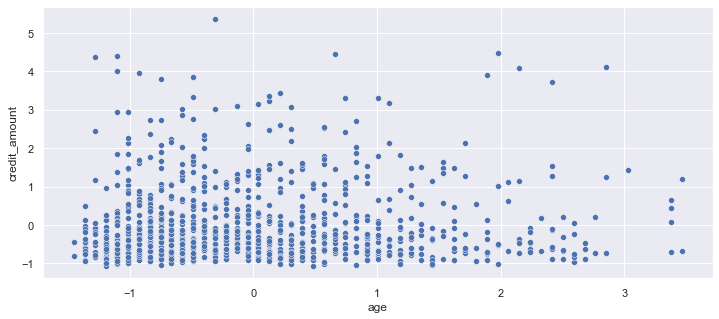

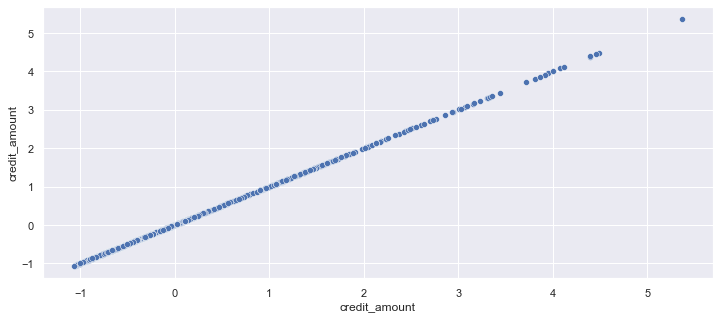

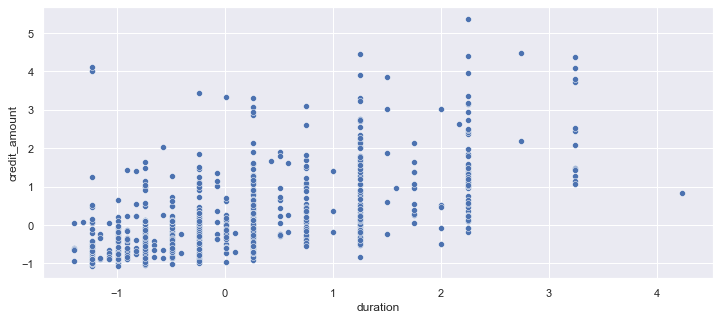

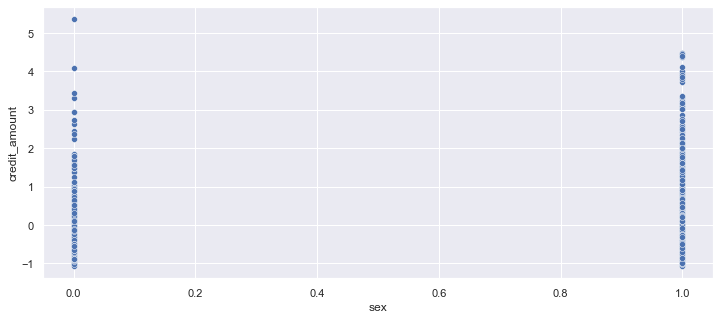

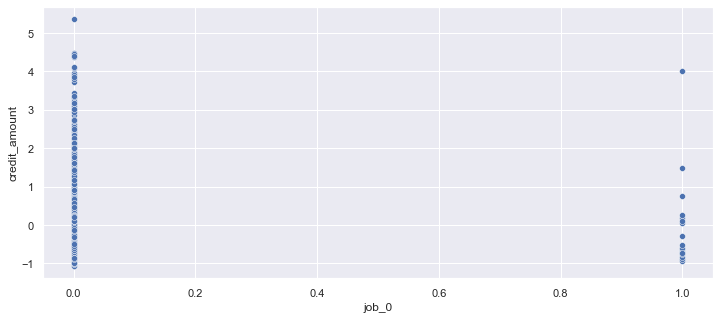

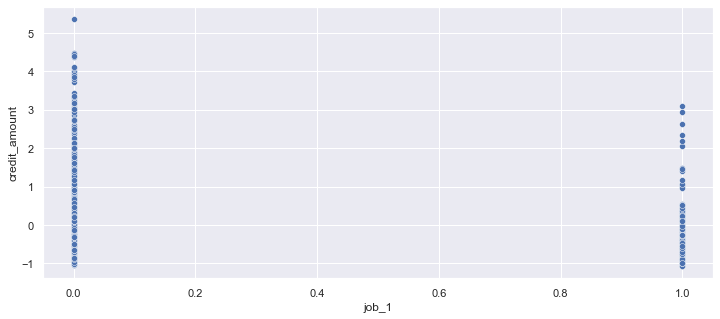

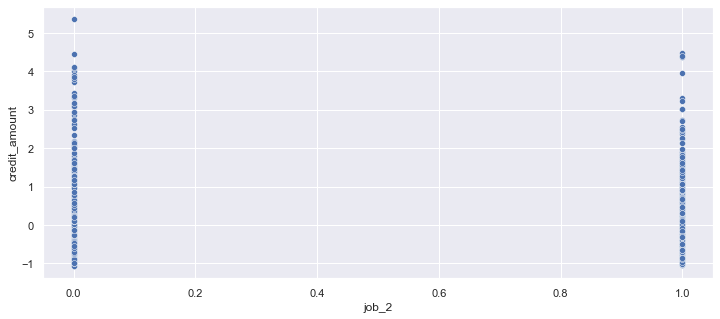

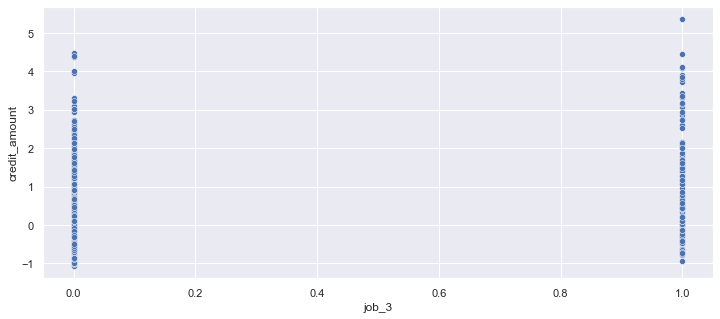

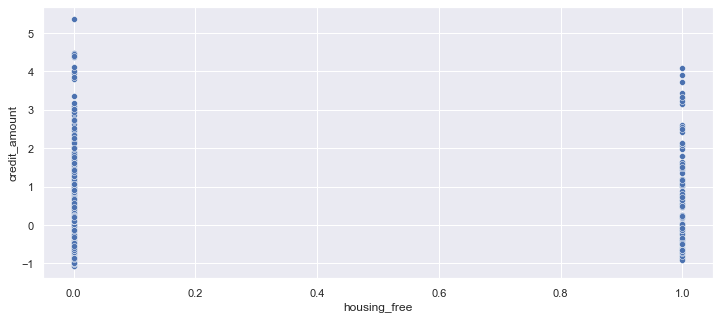

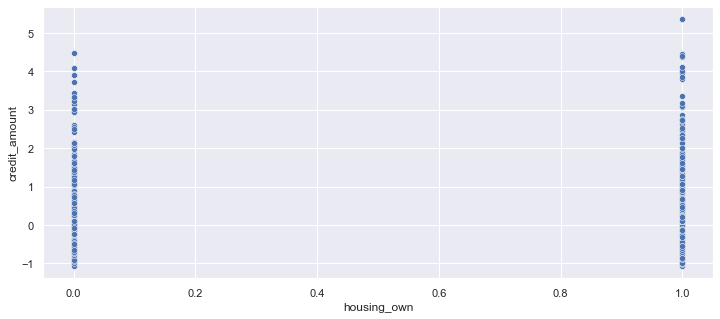

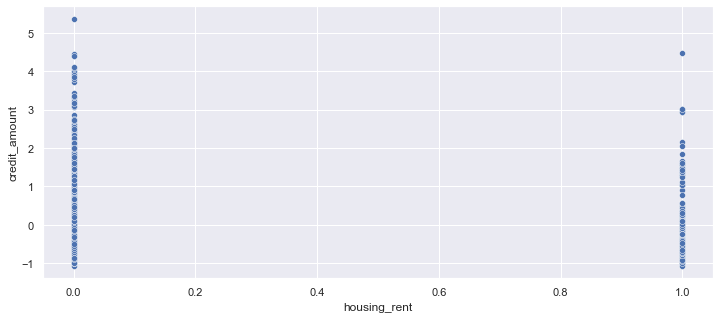

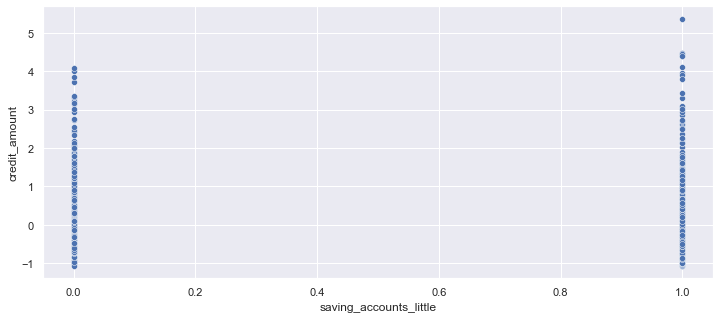

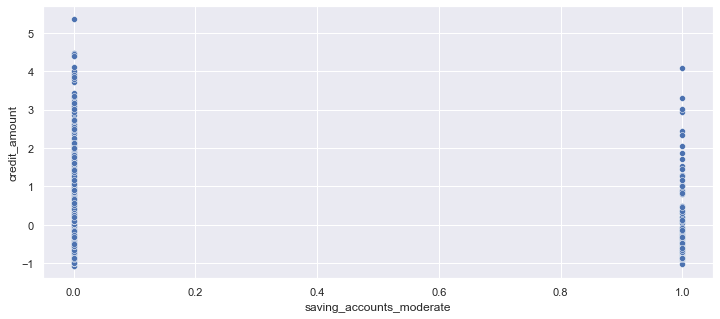

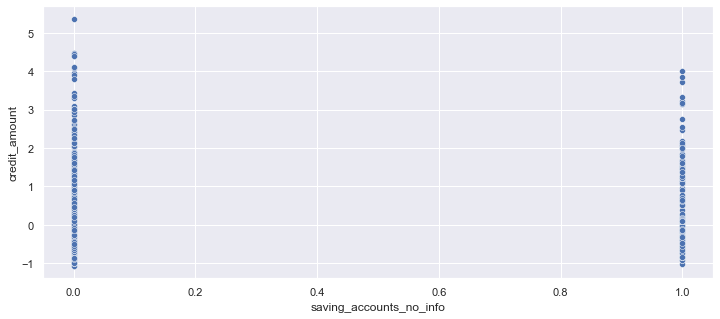

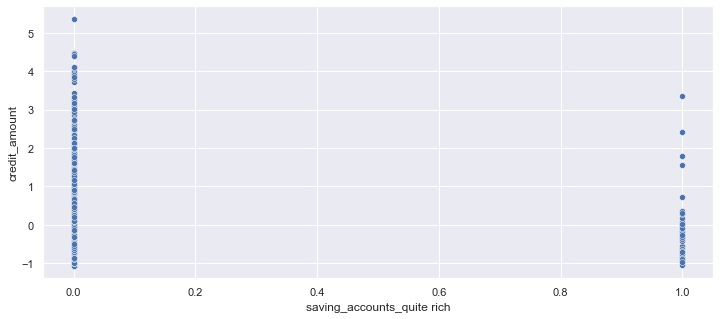

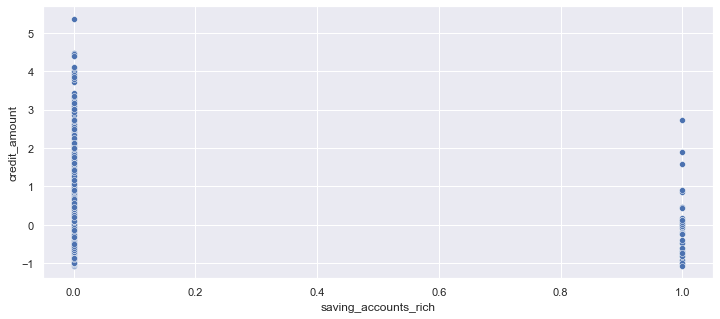

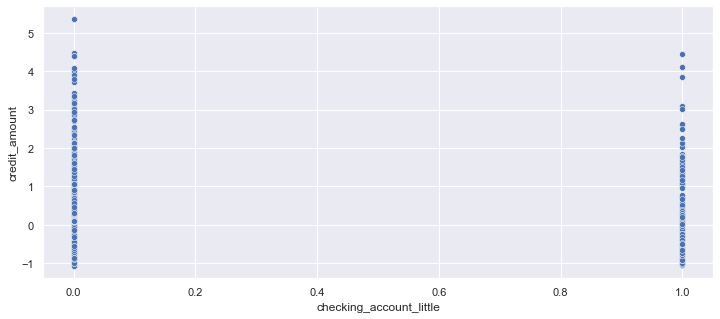

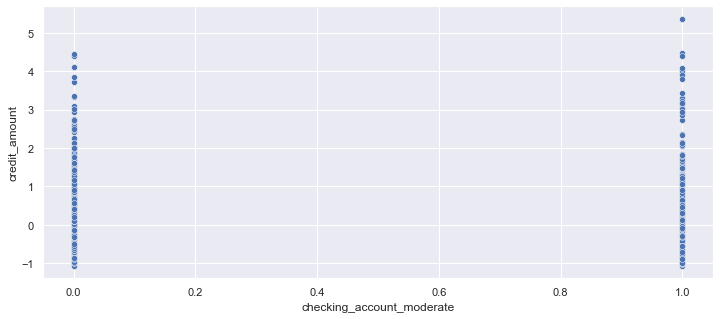

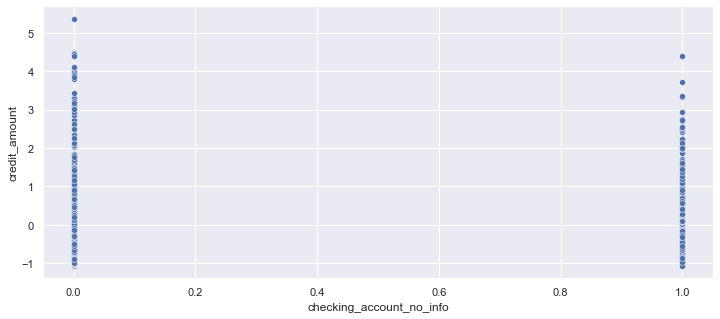

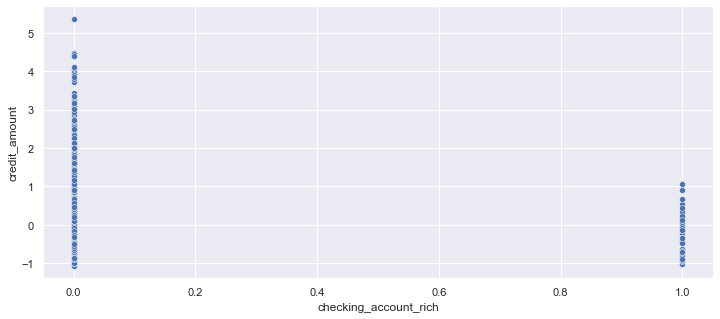

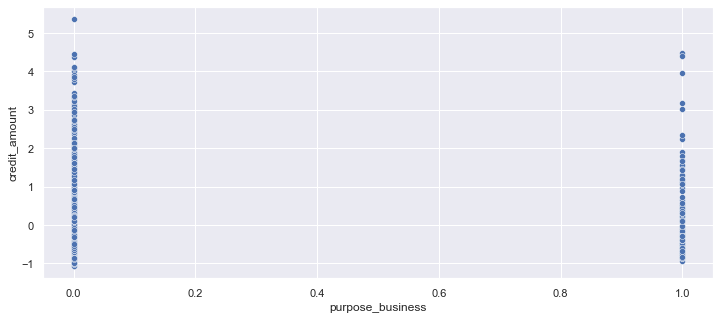

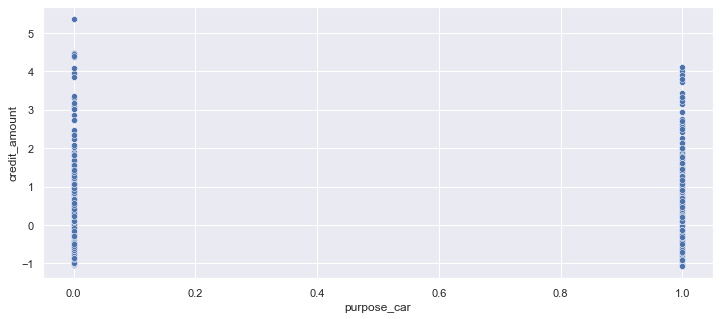

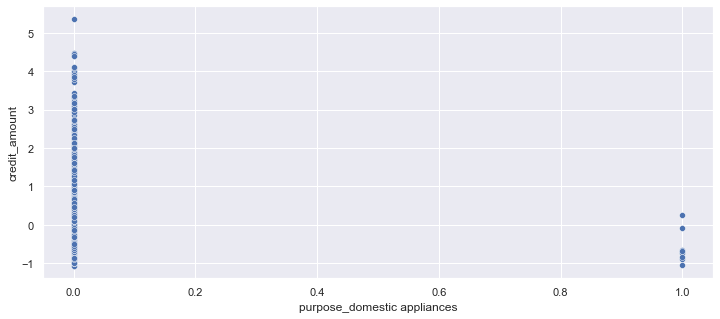

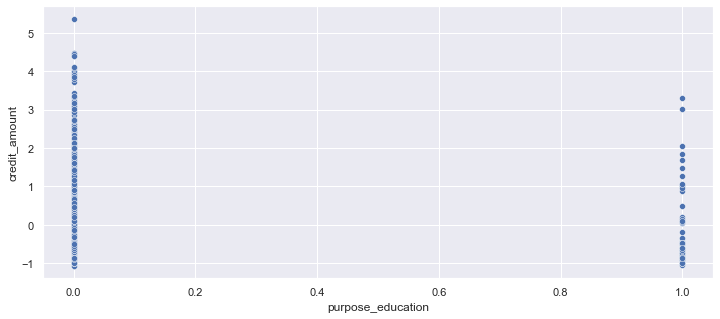

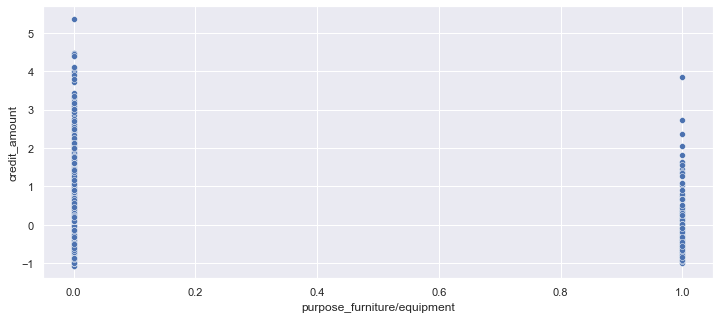

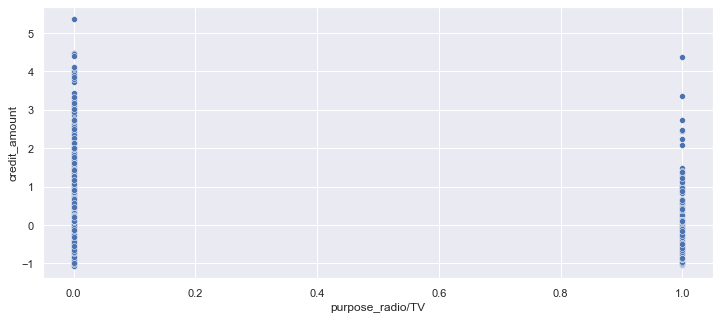

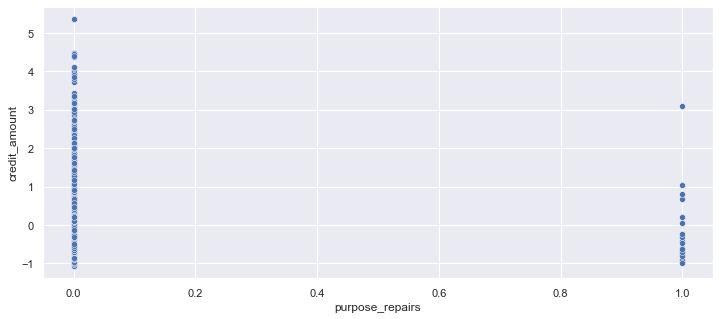

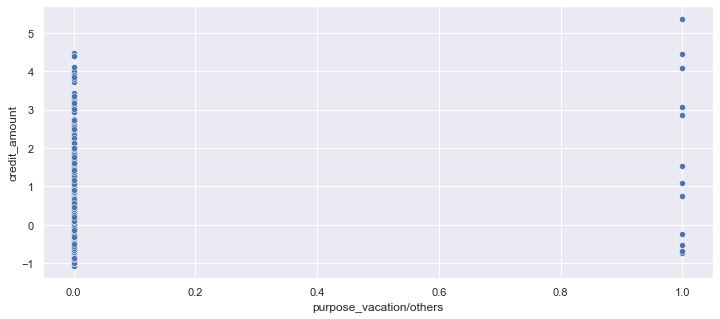

In [ ]:
#построим попарные диаграммы рассеяния признаков относительно размера кредита 
sns.set(rc={'figure.figsize':(12,5)})

for col in df_sc.columns:
    sns.scatterplot(x = df_sc[col], y = df_sc['credit_amount'])
    plt.show()

По duration и age похоже есть возможности разделения на кластера.

### Определение количества методом Elbow(локтя)

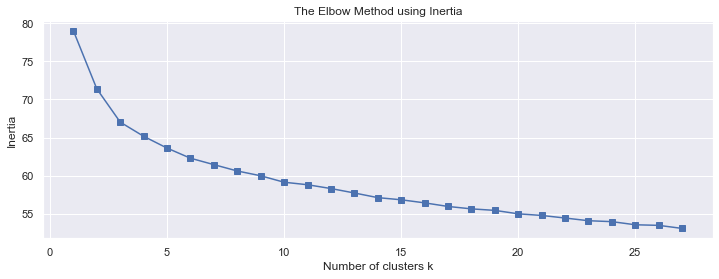

In [ ]:
k_max = 28

inertia = []
for k in range(1, k_max):

    kmeans = KMeans(n_clusters=k).fit(df_sc)
    
    inertia.append(np.sqrt(kmeans.inertia_))

plt.figure(figsize=(12, 4))
plt.plot(range(1, k_max), inertia, marker='s')

plt.title('The Elbow Method using Inertia')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')

plt.show()

Нам нужно найти на графике место где убывание инерции становится незначительным(перелом-локоть).

In [ ]:
d = {}
for k in range(2, k_max-1):
    i = k - 1
    d[k] = (inertia[i] - inertia[i + 1]) / (inertia[i - 1] - inertia[i])

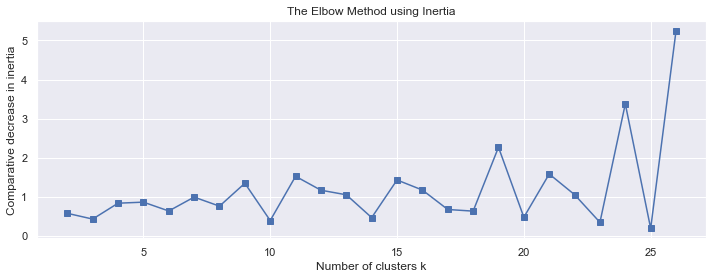

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(range(2, k_max-1), [x for x in d.values()], marker='s')

plt.title('The Elbow Method using Inertia')
plt.xlabel('Number of clusters k')
plt.ylabel('Comparative decrease in inertia')

plt.show()

У нас минимумы для 3,10,19 и 25х кластеров. Для простоты я бы выбрал 3, но посмотрим, что покажет метод выбора по метрике "Силуэт". 

### Выбор оптимального числа кластеров c K-Means (silhouette).



In [ ]:
# зададим модель k_means с количеством кластеров 3
km = KMeans(n_clusters = 3)
# спрогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 15)
labels = km.fit_predict(df_sc)

# посчитаем метрику силуэта для нашей кластеризации
print('Silhouette_score_3: {:.2f}'.format(silhouette_score(df_sc, labels)))

Silhouette_score_3: 0.16


In [ ]:
# зададим модель k_means с количеством кластеров 10
km = KMeans(n_clusters = 10)
# спрогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 5)
labels = km.fit_predict(df_sc)

# посчитаем метрику силуэта для нашей кластеризации
print('Silhouette_score_10: {:.2f}'.format(silhouette_score(df_sc, labels)))

Silhouette_score_10: 0.09


In [ ]:
# зададим модель k_means с количеством кластеров 19
km = KMeans(n_clusters = 19)
# спрогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 5)
labels = km.fit_predict(df_sc)

# посчитаем метрику силуэта для нашей кластеризации
print('Silhouette_score_19: {:.2f}'.format(silhouette_score(df_sc, labels)))

Silhouette_score_19: 0.09


In [ ]:
# зададим модель k_means с количеством кластеров 25
km = KMeans(n_clusters = 25)
# спрогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 5)
labels = km.fit_predict(df_sc)

# посчитаем метрику силуэта для нашей кластеризации
print('Silhouette_score_25: {:.2f}'.format(silhouette_score(df_sc, labels)))

Silhouette_score_25: 0.09


Для 3 кластеров метрика "Силуэт" показала большее значение, поэтому считаем, что 3 кластеров это оптимальное количество кластеров для K-means. 

### Выбор оптимального числа кластеров c помощью иерархической дендрограммы (silhouette).


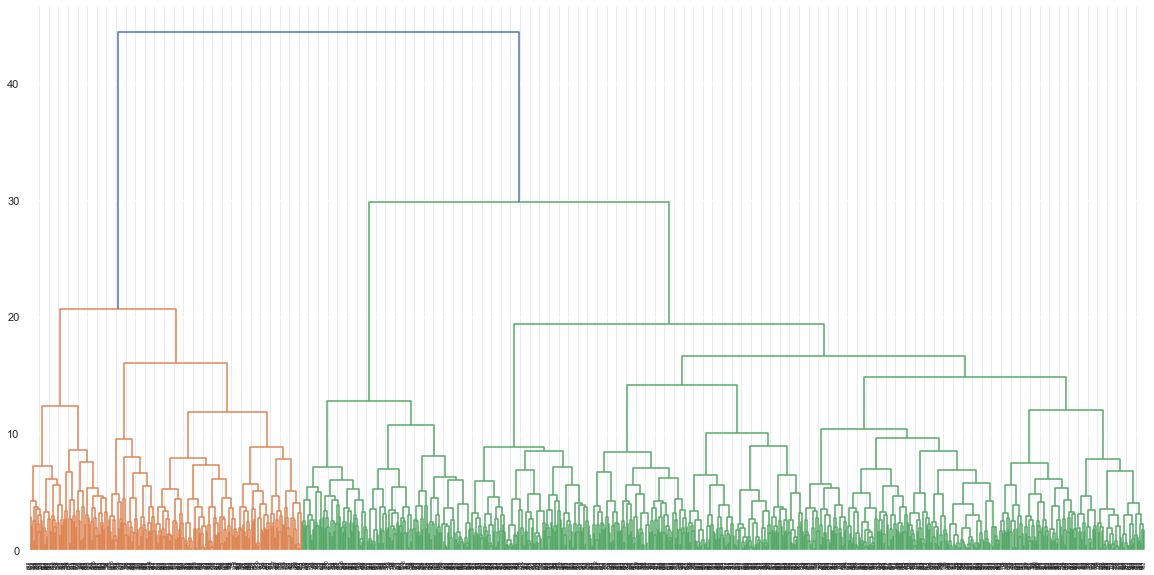

In [ ]:
plt.figure(figsize=(20,10))
linkage_ = linkage(df_sc, method='ward')
dendrogram_ = dendrogram(linkage_)

In [ ]:
# посчитаем метрику для 2 кластеров
agg = AgglomerativeClustering(n_clusters=2).fit(df_sc)
labels = agg.labels_
silhouette_score(df_sc, labels)


0.19062869158142143

In [ ]:
# посчитаем метрику для 3 кластеров
agg = AgglomerativeClustering(n_clusters=3).fit(df_sc)
labels = agg.labels_
silhouette_score(df_sc, labels)

0.1295765352269232

In [ ]:
# посчитаем метрику для 10 кластеров
agg = AgglomerativeClustering(n_clusters=10).fit(df_sc)
labels = agg.labels_
silhouette_score(df_sc, labels)

0.05395445840990636

In [ ]:
# посчитаем метрику для 19 кластеров
agg = AgglomerativeClustering(n_clusters=19).fit(df_sc)
labels = agg.labels_
silhouette_score(df_sc, labels)

0.041913555332748584

In [ ]:
# посчитаем метрику для 25 кластеров
agg = AgglomerativeClustering(n_clusters=25).fit(df_sc)
labels = agg.labels_
silhouette_score(df_sc, labels)

0.053957274663935975

Метрика показывает лучшее значение для 2 кластеров. 

## Выбор оптимального числа кластеров с помощью DBSCAN

введем функцию для визуализации перебора радиуса поиска соседей и вывода графика силуэт/количество кластеров.

In [ ]:
def dbscan_clustering(eps_range, X):
    eps_range = eps_range
    silhouette = []
    clusters = []
    for i in tqdm(eps_range):
        dbscan = DBSCAN(eps=i).fit(X)
        labels = dbscan.labels_
        uniq_labels = np.unique(labels)
        n_clusters = len(uniq_labels[uniq_labels != -1])
        if n_clusters > 1:
            score = silhouette_score(X, labels)
        else:
            score = 0
        silhouette.append(score)
        clusters.append(n_clusters)
        
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.plot(eps_range, silhouette, marker='o', color=color)
    ax1.set_xlabel('eps')
    ax1.set_ylabel('silhouette', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.plot(eps_range, clusters, marker='o', color=color)
    ax2.set_ylabel('n_clusters', color=color)  
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

100%|██████████| 90/90 [00:15<00:00,  5.79it/s]


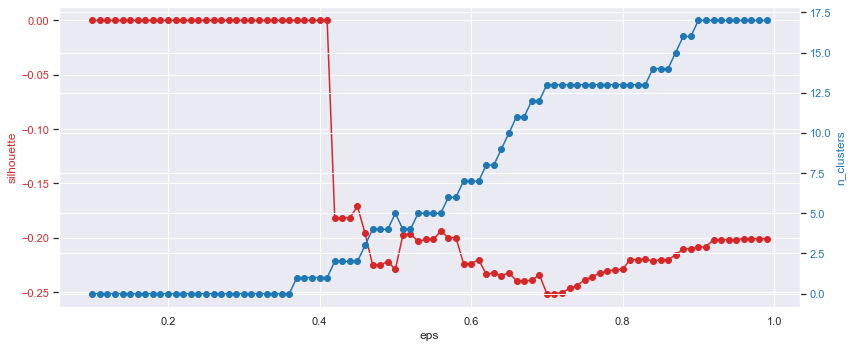

In [ ]:
eps_range = np.arange(0.1,1,0.01)
dbscan_clustering(eps_range, df_sc)

Силуэт достигает максимальных значений при числе кластеров около 2. 

Посчитаем методами K-Means метрику Силуэт для 2х кластеров. 

In [ ]:
# зададим модель k_means с количеством кластеров 2
km = KMeans(n_clusters = 2)
# спрогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 1)
labels = km.fit_predict(df_sc)

# посчитаем метрику силуэта для нашей кластеризации
print('Silhouette_score_2: {:.2f}'.format(silhouette_score(df_sc, labels)))

Silhouette_score_2: 0.23


Все таки для 2 кластеров получаются максимальные значения метрики Силуэт. Считаем, что 2 кластера это оптимальный вариант.

# 3.Посмотрим на кластера в 2D применяя различные методы сжатия пространства

### Метод PCA

Для выбора числа компонент применим метод доли объясненной дисперсии


In [ ]:
df_sc.head()

,age,credit_amount,duration,sex,job_0,job_1,job_2,job_3,housing_free,housing_own,...,checking_account_no_info,checking_account_rich,purpose_business,purpose_car,purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_radio/TV,purpose_repairs,purpose_vacation/others
0,2.766456,-0.745131,-1.236478,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,-1.191404,0.949817,2.248194,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,1.183312,-0.416562,-0.738668,1,0,1,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
3,0.831502,1.634247,1.750384,1,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,1.535122,0.566664,0.256953,1,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
#найдем направления осей с максимальной дисперсией
pca = PCA()
pca.fit(df_sc)
# найдем дисперсии кумулятивным итогом и вычислим размерность дающую объяснение 90% дисперсии
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.9) + 1
d

13

In [ ]:
# тоже для 95% дисперсии
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

16

16 компонент объясняют 95% дисперсии. для обучения применим 16 компонент

In [ ]:
X_16_dim = df_sc.iloc[:, :16]
X_16_dim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         1000 non-null   float64
 1   credit_amount               1000 non-null   float64
 2   duration                    1000 non-null   float64
 3   sex                         1000 non-null   int32  
 4   job_0                       1000 non-null   uint8  
 5   job_1                       1000 non-null   uint8  
 6   job_2                       1000 non-null   uint8  
 7   job_3                       1000 non-null   uint8  
 8   housing_free                1000 non-null   uint8  
 9   housing_own                 1000 non-null   uint8  
 10  housing_rent                1000 non-null   uint8  
 11  saving_accounts_little      1000 non-null   uint8  
 12  saving_accounts_moderate    1000 non-null   uint8  
 13  saving_accounts_no_info     1000 n

применим алгоритм K-means к датасету с 16 компонентами выбрав параметр 2 кластера.

In [ ]:
kmeans = KMeans(n_clusters=2)

kmeans.fit(X_16_dim)

KMeans(n_clusters=2)

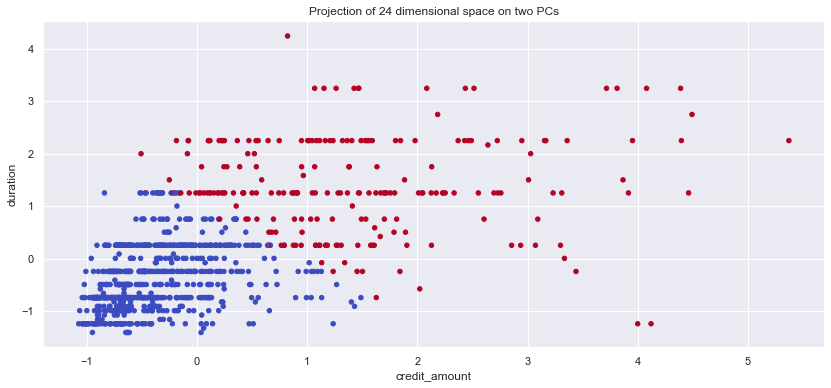

In [ ]:
#построим на 2D распределение объектов по credit_amount и duration                    
plt.figure(figsize=(14, 6))

plt.scatter(X_16_dim.iloc[:,1], X_16_dim.iloc[:,2], c=kmeans.labels_, s=20, cmap='coolwarm');

plt.title('Projection of 24 dimensional space on two PCs')
plt.xlabel('credit_amount')
plt.ylabel('duration')
plt.show()

Для признаков, которые изначально были числовыми: "размер кредита" и "длительность" 2 кластера выглядят разделенными. 

## Метод t-SNE

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=10, perplexity = 30)
print(df_sc.shape)
X_tsne = tsne.fit_transform(df_sc)
print(X_tsne.shape)

(1000, 28)
(1000, 2)


Метод t-SNE позволил снизить размерность с 24 до 2х. 

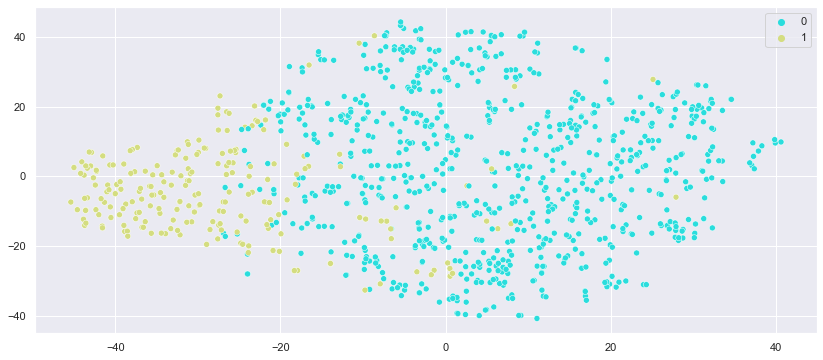

In [ ]:
plt.figure(figsize=(14, 6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=kmeans.labels_, palette='rainbow');

(1000, 2)


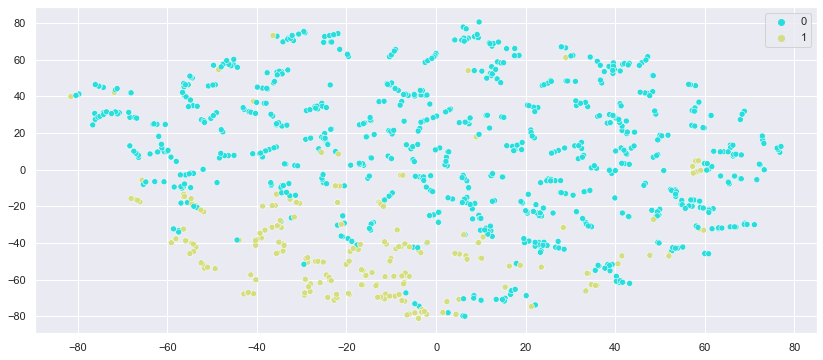

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=10, perplexity = 5)
X_tsne = tsne.fit_transform(df_sc)
print(X_tsne.shape)
plt.figure(figsize=(14, 6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=kmeans.labels_, palette='rainbow');

(1000, 2)


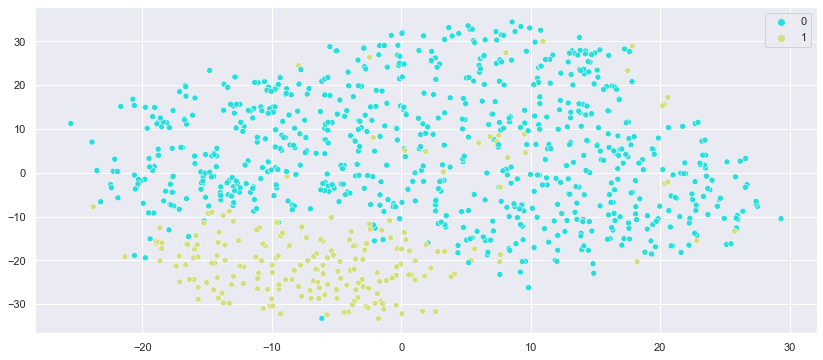

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=10, perplexity = 50)
X_tsne = tsne.fit_transform(df_sc)
print(X_tsne.shape)
plt.figure(figsize=(14, 6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=kmeans.labels_, palette='rainbow');

На мой взгляд для perplexity = 30 наиболее оптимальная картира разделения.

## UMAP

In [ ]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_sc)
embedding.shape

(1000, 2)

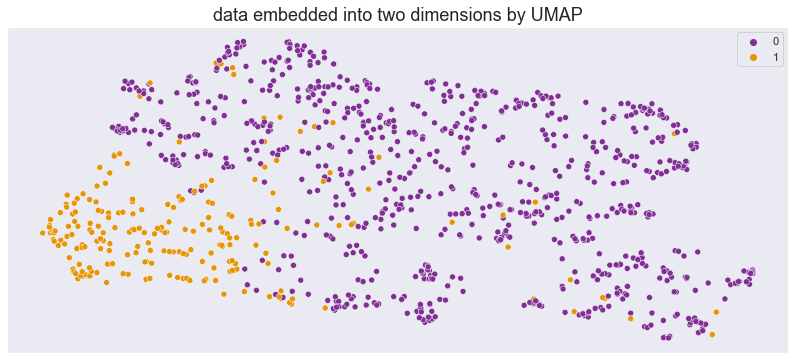

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.scatterplot(
    x=embedding[:, 0], 
    y=embedding[:, 1], 
    hue=kmeans.labels_, 
    palette="CMRmap", 
    legend='full'
)
plt.setp(ax, xticks=[], yticks=[])
plt.title("data embedded into two dimensions by UMAP", fontsize=18)

plt.show()

Разделение на 2 кластера выглядит успешно.

# 4.Интерпретация.

## Расчет средних по признакам с группировкой по кластерам

Закодированные категориальные переменные храняться в датафрейме df_o. Присоединим к нему столбцы с вещественными переменными до масштабирования.

In [ ]:
df_nosc = df_o.join(df[['age', 'credit_amount', 'duration']])


Добавим столбец с метками к датасету с переменными без масштабирования. 

In [ ]:
df_nosc['labels'] = kmeans.labels_
df_nosc.head()

,sex,job_0,job_1,job_2,job_3,housing_free,housing_own,housing_rent,saving_accounts_little,saving_accounts_moderate,...,purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_radio/TV,purpose_repairs,purpose_vacation/others,age,credit_amount,duration,labels
0,1,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,67,1169,6,0
1,0,0,0,1,0,0,1,0,1,0,...,0,0,0,1,0,0,22,5951,48,1
2,1,0,1,0,0,0,1,0,1,0,...,0,1,0,0,0,0,49,2096,12,0
3,1,0,0,1,0,1,0,0,1,0,...,0,0,1,0,0,0,45,7882,42,1
4,1,0,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,53,4870,24,0


In [ ]:
df_nosc['labels'].value_counts(normalize=True)

0    0.783
1    0.217
Name: labels, dtype: float64

кластера имеют разное количество объектов.

In [ ]:
df_nosc.groupby('labels').agg(['mean']).T.round(2)

,labels,0,1
sex,mean,0.67,0.76
job_0,mean,0.02,0.02
job_1,mean,0.23,0.07
job_2,mean,0.64,0.59
job_3,mean,0.10,0.32
housing_free,mean,0.07,0.24
housing_own,mean,0.74,0.63
housing_rent,mean,0.19,0.13
saving_accounts_little,mean,0.61,0.59
saving_accounts_moderate,mean,0.10,0.10


Кластер с индексом 0 отличается от кластера с индексом 1, тем что в нем клиенты  имеют меньшие размеры кредита и меньшую длительность кредита. По всем остальным признакам в обоих кластерах либо больше 0,5 либо меньше 0,5, что говорит о том, что по этим признакам кластера не отличаются. 

## Исследование разброса по кластерам

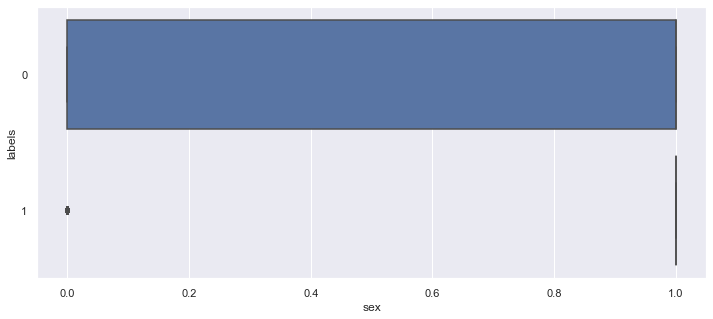

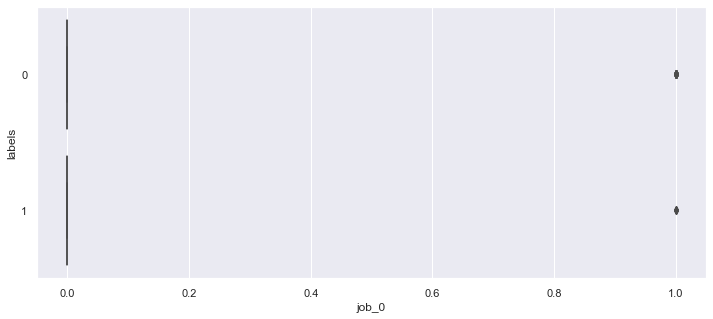

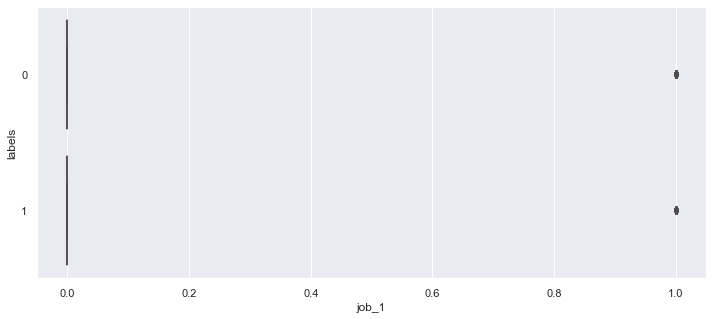

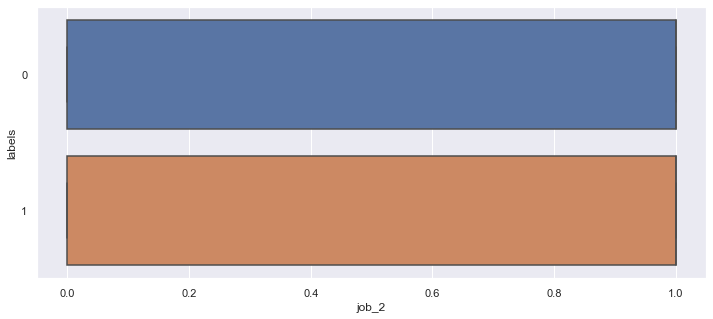

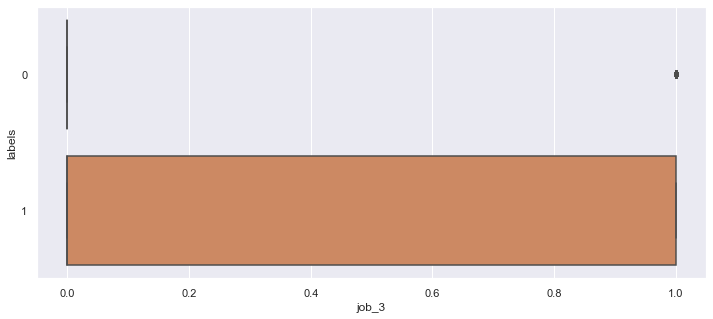

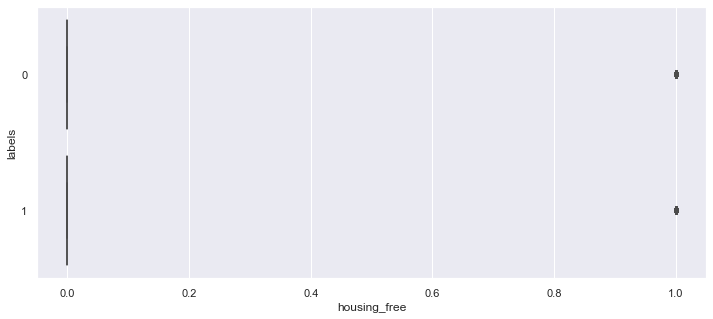

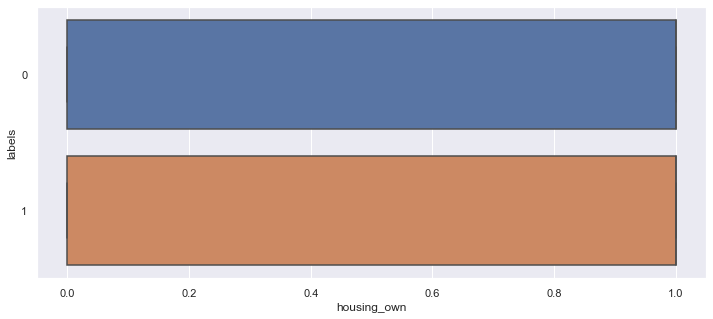

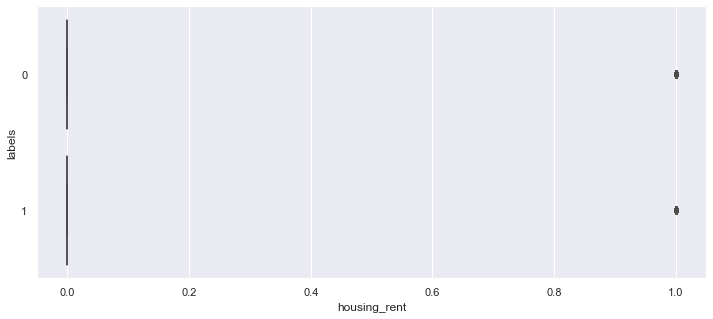

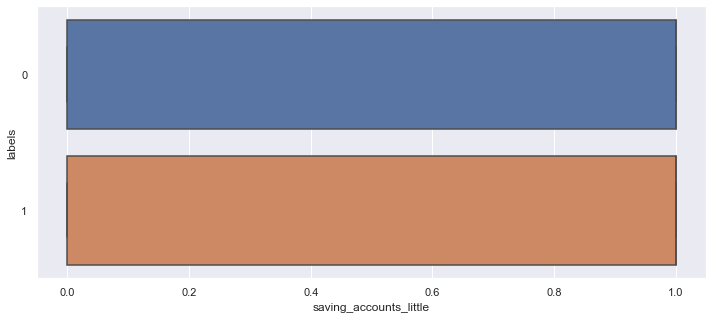

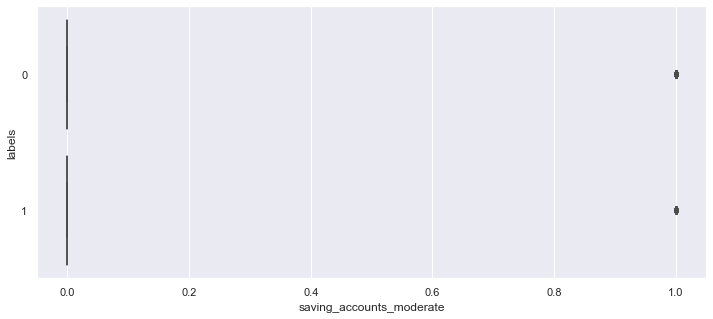

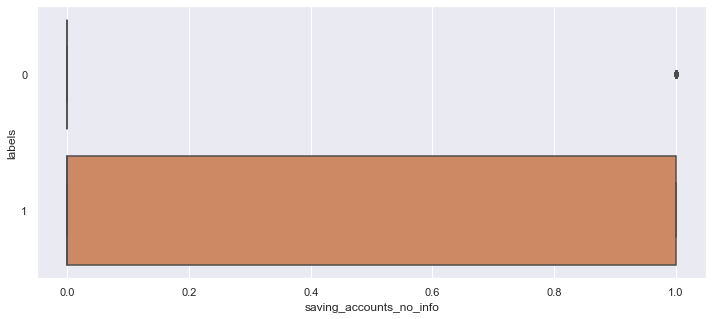

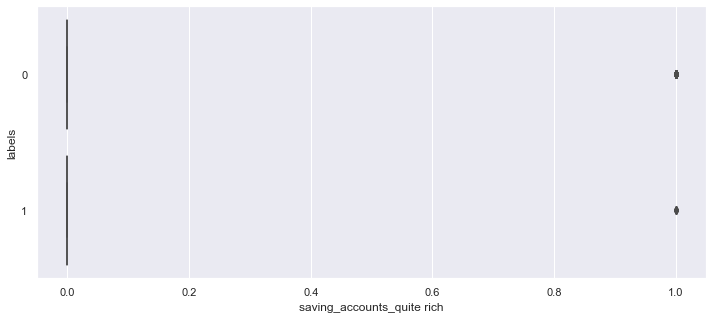

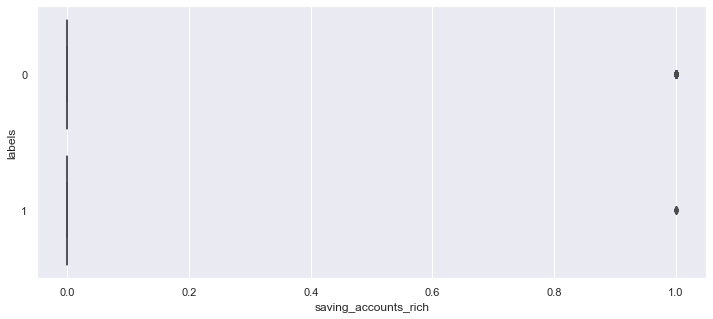

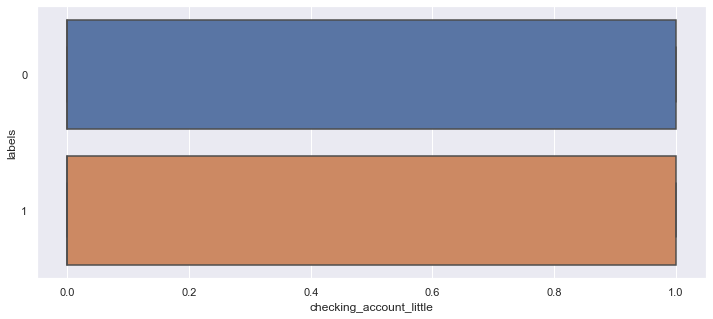

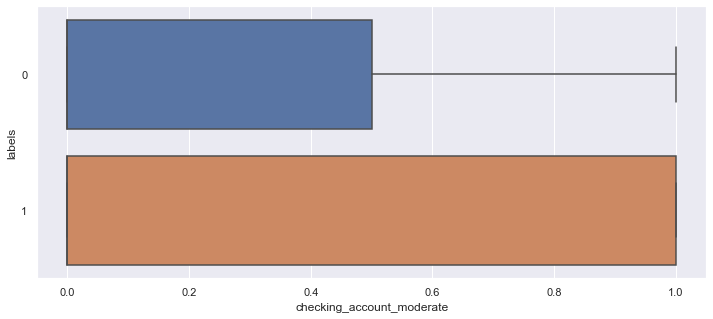

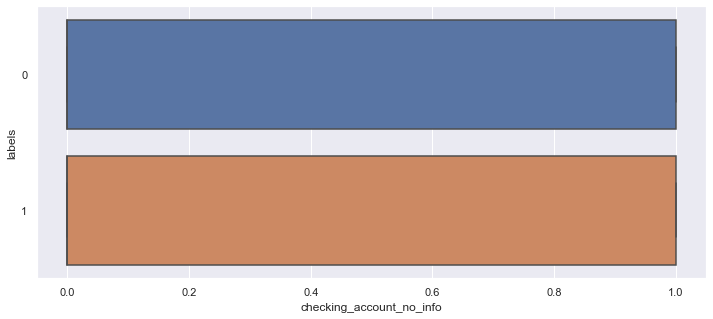

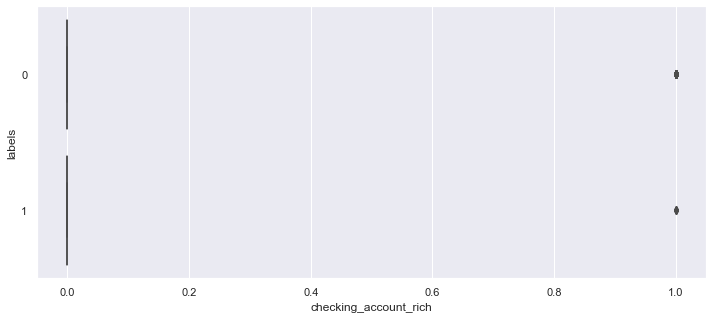

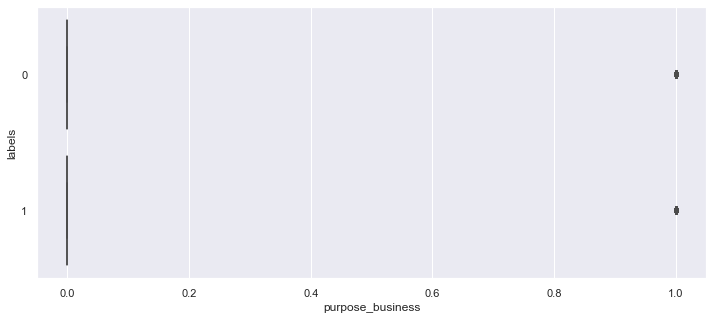

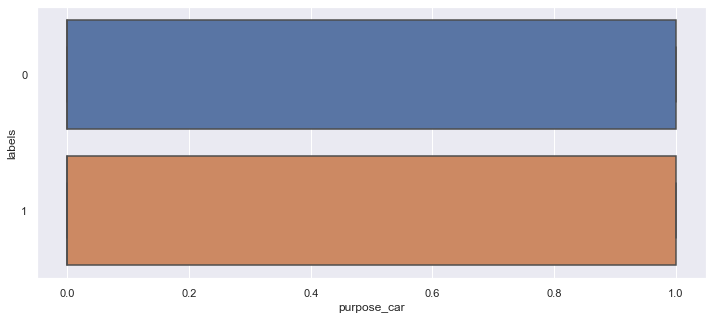

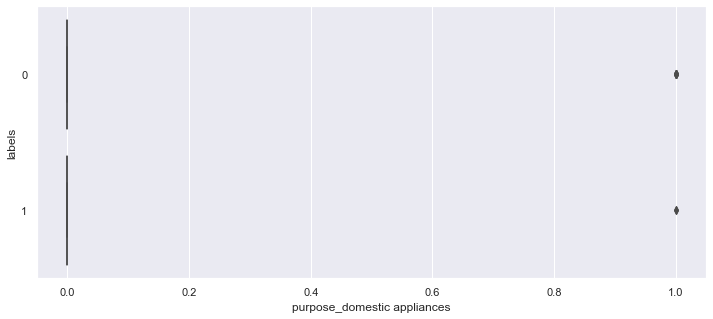

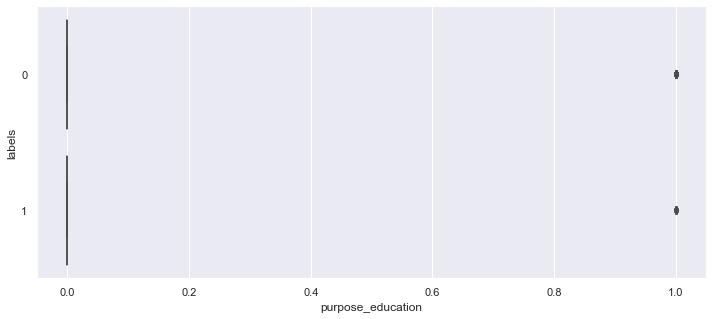

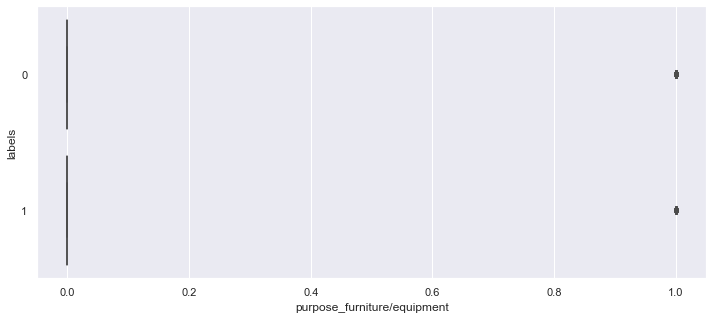

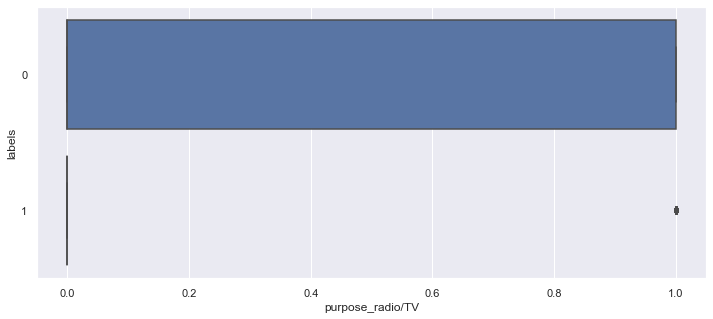

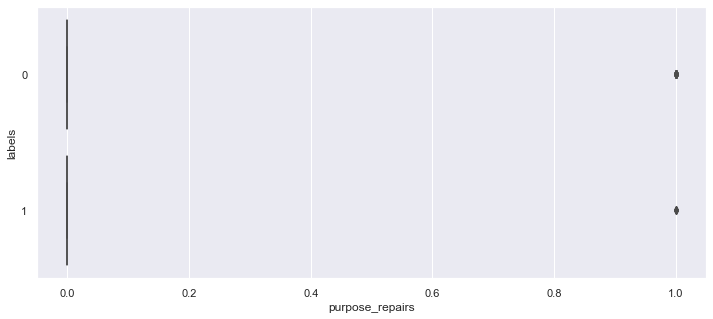

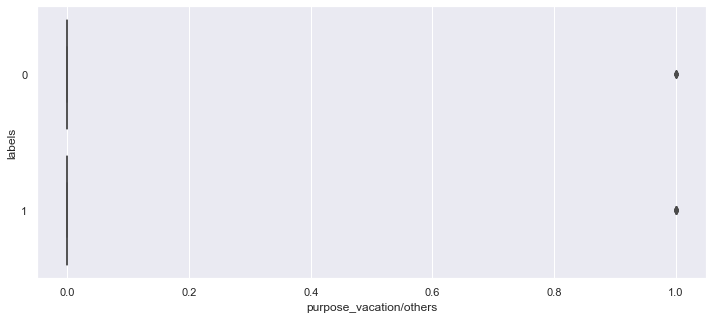

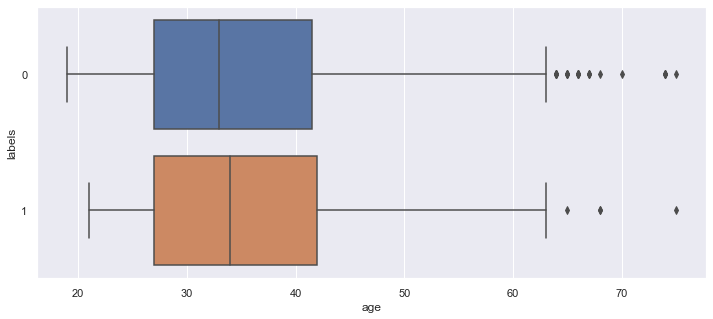

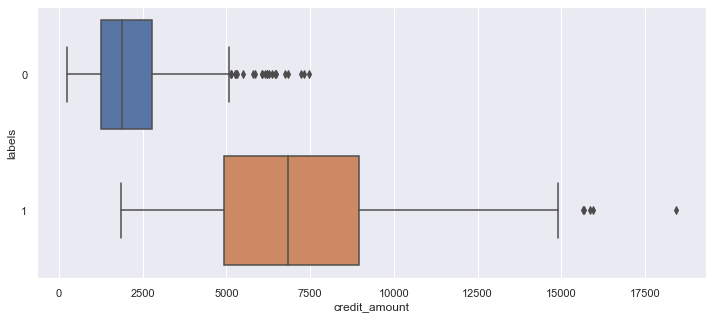

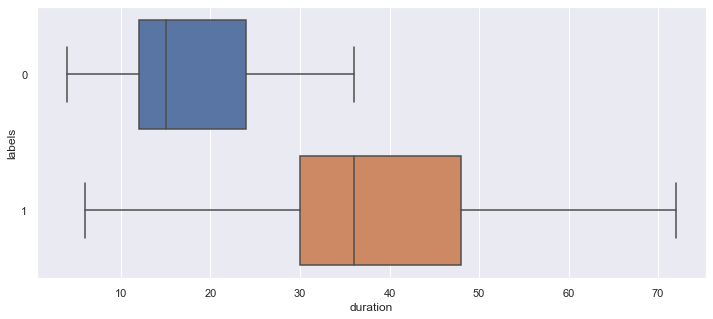

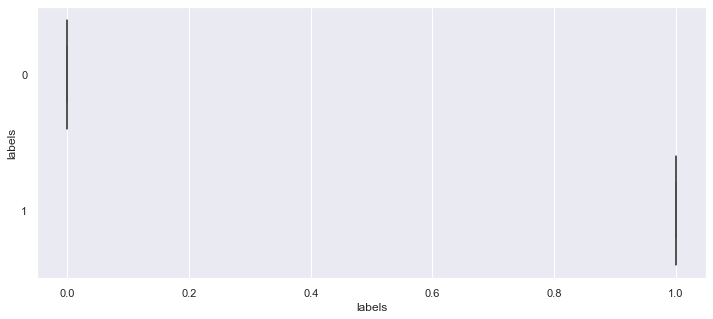

In [ ]:
sns.set(rc={'figure.figsize':(12,5)})
for col in df_nosc.columns:
    sns.boxplot(data=df_nosc, x=col, y=df_nosc['labels'], orient='h')
    plt.show();

Кластера отличаются по сумме и длительности кредита, кредитованием под радио и tv. 